In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv

In [2]:
# Function to parse train parameters from a CSV file
def parse_train_parameters(filename):
    params = {}
    
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        
        for row in reader:
            param_name = row[0].strip()
            param_value = float(row[1].strip())  # Convert values to float
            
            params[param_name] = param_value

    # Extract each parameter
    a = params.get('acceleration', 0)
    b = params.get('braking', 0)
    # Change from km/hr to m/s
    m = params.get('max_speed', 0) * 0.227
    A = params.get('A_coefficient', 0)
    B = params.get('B_coefficient', 0)
    C = params.get('C_coefficient', 0)
    mass_train = params.get('mass_train', 0)

    return a, b, m, A, B, C, mass_train

In [3]:
# Function to parse the stations CSV file
def parse_stations(filename):
    stations = []
    distances = []

    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        previous_chainage = 0
        
        for row in reader:
            chainage = float(row[0])  # Chainage in meters
            station_name = row[1]
            stations.append(station_name)
            
            if len(distances) > 0:
                distances.append(chainage - previous_chainage)  # Distance in meters
            else:
                distances.append(chainage)  # First station distance is from zero

            previous_chainage = chainage

    return distances, stations


In [4]:
# Function to parse the curves CSV file
def parse_curves(filename):
    curves = []
    
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        
        for row in reader:
            curve_start = float(row[0])
            curve_end = float(row[1])
            curve_radius = float(row[2])
            curves.append((curve_start, curve_end, curve_radius))
        
        print(f'Curve data: {curves}')
    return curves


In [5]:
# Function to parse the gradients CSV file
def parse_gradients(filename):
    gradients = []
    
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        
        for row in reader:
            gradient_start = float(row[0])
            gradient_end = float(row[1])
            gradient_ratio = float(row[2])
            gradients.append((gradient_start, gradient_end, gradient_ratio))

        print(f'Gradient data: {gradients}')
    return gradients


In [6]:
def train_resistance(v, A, B, C, mass_train, curve_resistance, gradient_resistance):
    """
    Calculate the total train resistance, including straight-line (frictional) resistance, curve resistance,
    and gradient resistance.

    Arguments:
    - v: Speed of the train in meters per second.
    - A, B, C: Resistance coefficients for straight-line resistance (per ton).
    - mass_train: Mass of the train in tons.
    - curve_resistance: Total curve resistance in Newtons (already calculated for the whole train).
    - gradient_resistance: Total gradient resistance in Newtons (already calculated for the whole train).

    Returns:
    - total_resistance: Total train resistance in Newtons (N).
    """
    # Davis formula: A + B*v + C*v^2 (Newton/ton)
    straight_line_resistance_per_ton = A + B * v + C * (v ** 2)
    
    # Total straight-line resistance for the whole train (in Newtons)
    straight_line_resistance = straight_line_resistance_per_ton * mass_train
    
    # Total resistance is the sum of straight-line resistance, curve resistance, and gradient resistance
    total_resistance = straight_line_resistance + curve_resistance + gradient_resistance
    
    return total_resistance


In [7]:
def calculate_curve_resistance(curve_radius, mass_train):
    """
    Calculate the resistance due to a curve, based on the curve radius and mass of the train.

    Arguments:
    - curve_radius: Radius of the curve in meters.
    - mass_train: Mass of the train in tons.

    Returns:
    - curve_resistance: The additional resistance encountered due to the curve in Newtons (N).
    """
    if curve_radius == 0:
        return 0  # No curve, no additional resistance
    
    # Using the empirical formula: 600/curve_radius (resistance per ton) * mass_train (in tons)
    return (600 / curve_radius) 


In [8]:
def calculate_gradient_resistance(gradient_ratio, mass_train):
    """
    Calculate the resistance due to a gradient.

    Arguments:
    - gradient_ratio: The gradient ratio (e.g., 100 for a 1 in 100 gradient).
    - mass_train: Mass of the train in tons.

    Returns:
    - gradient_resistance: The additional resistance due to the gradient in Newtons (N).
    """
    if gradient_ratio == 0:
        return 0  # No gradient, no additional resistance
    
    # Convert mass from tons to kilograms for proper units
    mass_train_kg = mass_train * 1000  # 1 ton = 1000 kg
    
    # Calculate gradient resistance: (mass * g) / gradient_ratio
    g = 9.81  # acceleration due to gravity in m/s²
    gradient_resistance = (mass_train_kg * g) / gradient_ratio
    
    return gradient_resistance


In [9]:
# Function to calculate coasting deceleration at a given speed
def coasting_deceleration(v, A, B, C, mass_train, curve_resistance=0, gradient_resistance=0):
    F_r = train_resistance(v, A, B, C, mass_train, curve_resistance, gradient_resistance)
    return -F_r / mass_train  # Deceleration is negative since it opposes motion


In [10]:
# Function to calculate average speed with reacceleration phase for a segment
def calculate_average_speed_with_reacceleration(d, a, b, m, A, B, C, mass_train, curve_resistance=0, gradient_resistance=0):
    # Time to accelerate and brake
    t_accel = m / a
    t_brake = m / b

    # Distance covered during acceleration and braking phases
    d_accel = 0.5 * a * t_accel**2
    d_brake = 0.5 * b * t_brake**2

    # Check if the train reaches max speed
    if d_accel + d_brake > d:
        # The train never reaches max speed
        t_total = np.sqrt(2 * d / (a + b)) if (a + b) > 0 else float('inf')
        avg_speed = d / t_total if t_total > 0 else 0
        return avg_speed, t_total, t_total / 2, 0, t_total / 2, 0  # t_coast = 0, reacceleration = 0
    else:
        # Distance to cover during coasting
        d_coast = d - (d_accel + d_brake)
        v = m  # starting speed for coasting
        dt = 0.1  # time step
        t_coast = 0

        # Threshold for speed to trigger re-acceleration
        speed_threshold = 0.9 * m
        reacceleration_times = 0

        while d_coast > 0:
            # Decelerate due to resistance
            decel = coasting_deceleration(v, A, B, C, mass_train, curve_resistance, gradient_resistance)
            v = max(0, v + decel * dt)  # Update velocity based on deceleration
            d_coast -= v * dt  # Update distance covered during this time step
            t_coast += dt

            # Re-accelerate if speed falls below the 90% threshold
            if v < speed_threshold:
                while v < m and d_coast > 0:
                    v = min(m, v + a * dt)  # Accelerate back to max speed
                    d_coast -= v * dt
                    t_coast += dt
                reacceleration_times += 1

        # Total time
        t_total = t_accel + t_coast + t_brake
        avg_speed = d / t_total if t_total > 0 else 0  # Safeguard against invalid time
        return avg_speed, t_total, t_accel, t_coast, t_brake, reacceleration_times


In [11]:
# Function to calculate cumulative resistances from curves and gradients in a segment
def calculate_cumulative_resistance(total_distance, curves, gradients, mass_train):
    curve_resistance = 0
    gradient_resistance = 0
    
    for curve_start, curve_end, curve_radius in curves:
        if curve_start <= total_distance <= curve_end:
            curve_resistance += calculate_curve_resistance(curve_radius, mass_train)
    
    for gradient_start, gradient_end, gradient_ratio in gradients:
        if gradient_start <= total_distance <= gradient_end:
            gradient_resistance += calculate_gradient_resistance(gradient_ratio, mass_train)

    return curve_resistance, gradient_resistance


In [12]:
# Function to plot speed vs time for multiple stations
def plot_speed_vs_time_with_reacceleration(distances, stations, a, b, m, A, B, C, mass_train, curves, gradients):
    total_time = 0
    time_points = []
    speed_points = []

    total_distance = 0

    for idx, d in enumerate(distances):
        # Calculate cumulative resistance from curves and gradients
        curve_resistance, gradient_resistance = calculate_cumulative_resistance(total_distance, curves, gradients, mass_train)

        avg_speed, segment_time, t_accel, t_coast, t_brake, reaccel_times = calculate_average_speed_with_reacceleration(
            d, a, b, m, A, B, C, mass_train, curve_resistance, gradient_resistance
        )
        
        time_points_segment = np.linspace(total_time, total_time + segment_time, 500)
        speed_points_segment = np.zeros_like(time_points_segment)

        for i in range(len(time_points_segment)):
            t = time_points_segment[i] - total_time
            if t < t_accel:
                speed_points_segment[i] = a * t
            elif t < t_accel + t_coast:
                v_prev = speed_points_segment[i-1] if i > 0 else m
                decel = coasting_deceleration(v_prev, A, B, C, mass_train, curve_resistance, gradient_resistance)
                speed_points_segment[i] = max(0, v_prev + decel * (time_points_segment[i] - time_points_segment[i-1]))
                if speed_points_segment[i] < 0.9 * m:
                    # Re-accelerate when speed drops below 90% of max speed
                    speed_points_segment[i] += a * (time_points_segment[i] - time_points_segment[i-1])
                    speed_points_segment[i] = min(m, speed_points_segment[i])  # Ensure speed goes back to max
            else:
                time_since_brake = t - t_accel - t_coast
                speed_points_segment[i] = max(0, m - b * time_since_brake)

        # Append time and speed points
        time_points.extend(time_points_segment)
        speed_points.extend(speed_points_segment)
        total_time += segment_time
        total_distance += d

    # Plot the speed vs time graph
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, speed_points)
    plt.title('Speed vs Time with Re-acceleration')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Speed (m/s)')
    plt.grid(True)
    plt.show()



In [13]:
# Reading CSV files
distances, stations = parse_stations("stations.csv")
curves = parse_curves("curves.csv")
gradients = parse_gradients("gradients.csv")

# Read Train Parameters
a, b, m, A, B, C, mass_train = parse_train_parameters("train_parameters.csv")

# Now you can use these parameters in the rest of your code.
print(f"Acceleration: {a}, Braking: {b}, Max Speed: {m}, A: {A}, B: {B}, C: {C}, Mass of Train: {mass_train}")


Curve data: [(0.0, 100.0, 200.0), (2200.0, 2350.0, 200.0), (4100.0, 4150.0, 400.0)]
Gradient data: [(4100.0, 4150.0, 400.0)]
Acceleration: 1.0, Braking: 1.2, Max Speed: 18.16, A: 14.0, B: 0.264, C: 0.00191, Mass of Train: 200.0


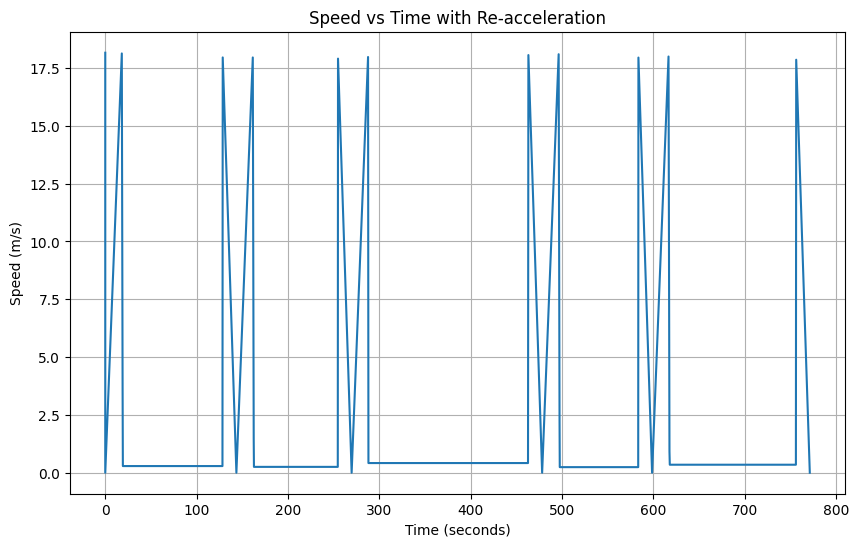

In [14]:
plot_speed_vs_time_with_reacceleration(distances, stations, a, b, m, A, B, C, mass_train, curves, gradients)
